## Download & extract dataset

In [ ]:
# Download dataset
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz

# Extract dataset
!tar -xf genres.tar.gz

--2021-01-03 08:58:00--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225571541 (1.1G) [application/x-gzip]
Saving to: ‘genres.tar.gz’

genres.tar.gz       100%[===================>]   1.14G  13.0MB/s    in 90s     

2021-01-03 08:59:30 (12.9 MB/s) - ‘genres.tar.gz’ saved [1225571541/1225571541]



## Parse dataset & load fields

In [165]:
import os
import pandas as pd
import numpy as np

# Parse genres
genres = [dir for dir in os.listdir('genres') if os.path.isdir(os.path.join('genres',dir))]

labels_ord = []
data_ord = []
data2_ord = []

# Extract mel frequency features
mels = librosa.feature.melspectrogram(y=song_data, sr=song_samprate, n_fft=2048, hop_length=1024)
mels = librosa.power_to_db(mels, ref=np.max)

# For each genre
for genre_id in range(len(genres)):
  print(genres[genre_id])

  # For each song of this genre
  for song_file in os.listdir(os.path.join('genres',genres[genre_id])):
    for i in range(4):
      # Load music file
      song_data, song_samprate = librosa.load(os.path.join('genres',genres[genre_id],song_file), mono=True, offset=i*7, duration=7)

      # Extract mel frequency features
      mels = librosa.feature.melspectrogram(y=song_data, sr=song_samprate, n_fft=2048, hop_length=1024)
      mels = librosa.power_to_db(mels, ref=np.max)

      mfcc = np.mean(librosa.feature.mfcc(y=song_data, sr=song_samprate, n_mfcc=20, hop_length=1024),axis=1)

      labels_ord.append(genre_id)
      data_ord.append(mels)
      data2_ord.append(mfcc)

labels_ord = np.array(labels_ord)
data_ord = np.expand_dims(np.array(data_ord),axis=3)
data2_ord = np.expand_dims(np.array(data2_ord),axis=(2,3))

rock
jazz
blues
country
reggae
disco
classical
metal
hiphop
pop


## Split data into training/validation sets.

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Shuffle dataset
shuffled_indices = np.random.permutation(labels_ord.shape[0])
labels = labels_ord[shuffled_indices]
data = data_ord[shuffled_indices,:,:,:]
data2 = data2_ord[shuffled_indices,:,:,:]

# Split dataset into training/validation/test sets
labels_train = labels[:np.ceil(0.80 * labels.shape[0]).astype(int)]
data_train = data[:np.ceil(0.80 * labels.shape[0]).astype(int),:,:,:]
data2_train = data2[:np.ceil(0.80 * labels.shape[0]).astype(int),:,:,:]

labels_valid = labels[np.ceil(0.80 * labels.shape[0]).astype(int):np.ceil(0.90 * labels.shape[0]).astype(int)]
data_valid = data[np.ceil(0.80 * labels.shape[0]).astype(int):np.ceil(0.90 * labels.shape[0]).astype(int),:,:,:]
data2_valid = data2[np.ceil(0.80 * labels.shape[0]).astype(int):np.ceil(0.90 * labels.shape[0]).astype(int),:,:,:]

labels_test = labels[np.ceil(0.90 * labels.shape[0]).astype(int):]
data_test = data[np.ceil(0.90 * labels.shape[0]).astype(int):,:,:,:]
data2_test = data2[np.ceil(0.90 * labels.shape[0]).astype(int):,:,:,:]

# One-hot encode labels
labels_train = to_categorical(labels_train,num_classes=10)
labels_valid = to_categorical(labels_valid,num_classes=10)
labels_test = to_categorical(labels_test,num_classes=10)

# Normalise features
norm_min = data_train.min()
norm_max = data_train.max()

data_train = (data_train - norm_min) / (norm_max - norm_min)
data_valid = (data_valid - norm_min) / (norm_max - norm_min)
data_test = (data_test - norm_min) / (norm_max - norm_min)

norm_min2 = data_train.min()
norm_max2 = data_train.max()

data2_train = (data2_train - norm_min2) / (norm_max2 - norm_min2)
data2_valid = (data2_valid - norm_min2) / (norm_max2 - norm_min2)
data2_test = (data2_test - norm_min2) / (norm_max2 - norm_min2)

## Custom data generator

In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np

batch_size = 64

class CustomGenerator(Sequence):
    def __init__(self, labels, data, batch_size):
        self.labels = labels
        self.data = data
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(self.data.shape[0]/float(self.batch_size)))

    def __getitem__(self, idx):
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array(batch_labels), np.array(batch_data)

# Create data generators
batch_generator_train = CustomGenerator(labels_train, data_train, batch_size)
batch_generator_valid = CustomGenerator(labels_valid, data_valid, batch_size)

## Create MLP model

In [166]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Initialise MLP network
model_mlp = Sequential()
model_mlp.add(Flatten(input_shape = (data_train.shape[1], data_train.shape[2], 1)))
model_mlp.add(Dense(256, activation='relu'))
model_mlp.add(Dense(128, activation='relu'))
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dense(10, activation='softmax'))
#model_mlp.summary()

# Compile network
model_mlp.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train network
history_mlp = model_mlp.fit(data_train, labels_train, 
                        batch_size=64, epochs=50,
                        validation_data=(data_valid, labels_valid))

Epoch 1/50
50/50 [==============================] - 1s 8ms/step - loss: 3.2867 - accuracy: 0.1202 - val_loss: 2.1156 - val_accuracy: 0.1875
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 2.1050 - accuracy: 0.1695 - val_loss: 2.0511 - val_accuracy: 0.2725
Epoch 3/50
50/50 [==============================] - 0s 6ms/step - loss: 2.0056 - accuracy: 0.2393 - val_loss: 1.9539 - val_accuracy: 0.3000
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 1.9053 - accuracy: 0.3129 - val_loss: 1.8957 - val_accuracy: 0.3200
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 1.8195 - accuracy: 0.3397 - val_loss: 1.8421 - val_accuracy: 0.3400
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 1.8247 - accuracy: 0.3418 - val_loss: 1.8054 - val_accuracy: 0.2975
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 1.7752 - accuracy: 0.3420 - val_loss: 1.8806 - val_accuracy: 0.2650
Epoch 8/50
50/50 [==

## Evaluate MLP model

13/13 [==============================] - 0s 3ms/step - loss: 1.3092 - accuracy: 0.5025
Test set accuracy: 0.5024999976158142
=== Class based accuracies ===
 rock: 0.2608695652173913
 jazz: 0.3157894736842105
 blues: 0.6341463414634146
 country: 0.5
 reggae: 0.2765957446808511
 disco: 0.4583333333333333
 classical: 0.7857142857142857
 metal: 0.8461538461538461
 hiphop: 0.08695652173913043
 pop: 0.7380952380952381


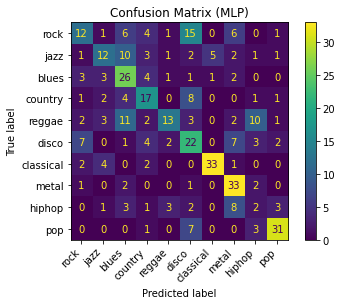

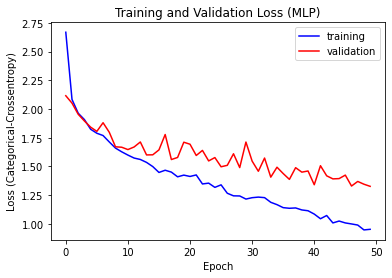

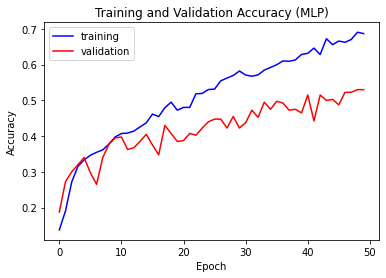

In [167]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Evaluate model on test set
pred_mlp = model_mlp.predict(data_test)
_, acc_mlp = model_mlp.evaluate(data_test, labels_test)
confm_mlp = metrics.confusion_matrix(labels_test.argmax(axis=1), pred_mlp.argmax(axis=1))
class_acc_mlp = confm_mlp.diagonal()/confm_mlp.sum(axis=1)

print('Test set accuracy: ' + str(acc_mlp))
print('=== Class based accuracies ===')
for genre_id in range(len(genres)):
  print(' ' + genres[genre_id] + ': ' + str(class_acc_mlp[genre_id]))

confm_disp = ConfusionMatrixDisplay(confusion_matrix=confm_mlp, display_labels=genres)
confm_disp.plot()
confm_disp.ax_.set_xticklabels(genres, rotation=45, ha='right')
plt.title('Confusion Matrix (MLP)')

# Extract training/validation losses
loss_train_mlp = history_mlp.history['loss']
loss_valid_mlp = history_mlp.history['val_loss']

# Plot training/validation losses
plt.figure()
plt.plot(loss_train_mlp, color='blue')
plt.plot(loss_valid_mlp, color='red')
plt.title('Training and Validation Loss (MLP)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Categorical-Crossentropy)')
plt.legend(['training','validation'])

# Extract training/validation accuracies
acc_train_mlp = history_mlp.history['accuracy']
acc_valid_mlp = history_mlp.history['val_accuracy']

# Plot training/validation accuracies
plt.figure()
plt.plot(acc_train_mlp, color='blue')
plt.plot(acc_valid_mlp, color='red')
plt.title('Training and Validation Accuracy (MLP)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['training','validation'])

## Create MLP model (with MFCC features)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Initialise MLP network
model_mlp_mfcc = Sequential()
model_mlp_mfcc.add(Flatten(input_shape = (data2_train.shape[1], data2_train.shape[2], 1)))
model_mlp_mfcc.add(Dense(64, activation='relu'))
model_mlp_mfcc.add(Dense(32, activation='relu'))
model_mlp_mfcc.add(Dense(10, activation='softmax'))
#model_mlp_mfcc.summary()

# Compile network
model_mlp_mfcc.compile(optimizer=Adam(learning_rate=0.005),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train network
history_mlp_mfcc = model_mlp_mfcc.fit(data2_train, labels_train, 
                                      batch_size=64, epochs=50,
                                      validation_data=(data2_valid, labels_valid))

Epoch 1/50
50/50 [==============================] - 1s 5ms/step - loss: 11.1330 - accuracy: 0.1895 - val_loss: 2.0041 - val_accuracy: 0.2775
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 2.0097 - accuracy: 0.2724 - val_loss: 1.8127 - val_accuracy: 0.3900
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 1.7731 - accuracy: 0.3665 - val_loss: 1.6589 - val_accuracy: 0.4100
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 1.6041 - accuracy: 0.4249 - val_loss: 1.5378 - val_accuracy: 0.4675
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 1.5645 - accuracy: 0.4643 - val_loss: 1.5566 - val_accuracy: 0.4800
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 1.4649 - accuracy: 0.4846 - val_loss: 1.5029 - val_accuracy: 0.5000
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.4939 - val_loss: 1.4473 - val_accuracy: 0.5175
Epoch 8/50
50/50 [=

## Evaluate MLP model (with MFCC features)

13/13 [==============================] - 0s 2ms/step - loss: 0.9978 - accuracy: 0.6875
Test set accuracy: 0.6875
=== Class based accuracies ===
 rock: 0.5434782608695652
 jazz: 0.6842105263157895
 blues: 0.7073170731707317
 country: 0.47058823529411764
 reggae: 0.6595744680851063
 disco: 0.6041666666666666
 classical: 0.8809523809523809
 metal: 0.8461538461538461
 hiphop: 0.391304347826087
 pop: 0.9523809523809523


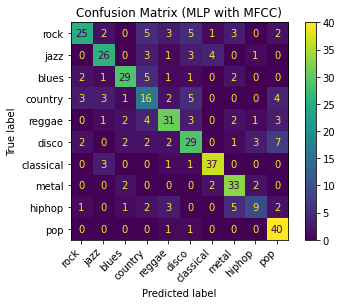

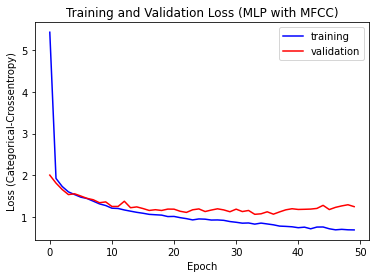

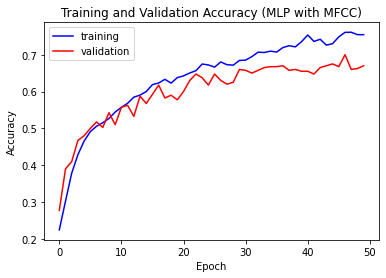

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Evaluate model on test set
pred_mlp_mfcc = model_mlp_mfcc.predict(data2_test)
_, acc_mlp_mfcc = model_mlp_mfcc.evaluate(data2_test, labels_test)
confm_mlp_mfcc = metrics.confusion_matrix(labels_test.argmax(axis=1), pred_mlp_mfcc.argmax(axis=1))
class_acc_mlp_mfcc = confm_mlp_mfcc.diagonal()/confm_mlp_mfcc.sum(axis=1)

print('Test set accuracy: ' + str(acc_mlp_mfcc))
print('=== Class based accuracies ===')
for genre_id in range(len(genres)):
  print(' ' + genres[genre_id] + ': ' + str(class_acc_mlp_mfcc[genre_id]))

confm_disp = ConfusionMatrixDisplay(confusion_matrix=confm_mlp_mfcc, display_labels=genres)
confm_disp.plot()
confm_disp.ax_.set_xticklabels(genres, rotation=45, ha='right')
plt.title('Confusion Matrix (MLP with MFCC)')

# Extract training/validation losses
loss_train_mlp_mfcc = history_mlp_mfcc.history['loss']
loss_valid_mlp_mfcc = history_mlp_mfcc.history['val_loss']

# Plot training/validation losses
plt.figure()
plt.plot(loss_train_mlp_mfcc, color='blue')
plt.plot(loss_valid_mlp_mfcc, color='red')
plt.title('Training and Validation Loss (MLP with MFCC)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Categorical-Crossentropy)')
plt.legend(['training','validation'])

# Extract training/validation accuracies
acc_train_mlp_mfcc = history_mlp_mfcc.history['accuracy']
acc_valid_mlp_mfcc = history_mlp_mfcc.history['val_accuracy']

# Plot training/validation accuracies
plt.figure()
plt.plot(acc_train_mlp_mfcc, color='blue')
plt.plot(acc_valid_mlp_mfcc, color='red')
plt.title('Training and Validation Accuracy (MLP with MFCC)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['training','validation'])

## Create CNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Initialise CNN network
model_cnn = Sequential()
model_cnn.add(Conv2D(8, (5,5), activation='relu', input_shape=(data.shape[1], data.shape[2], 1)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(16, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dense(10, activation='softmax'))
#model_cnn.summary()

# Compile network
model_cnn.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train network
history_cnn = model_cnn.fit(data_train, labels_train, 
                            batch_size=64, epochs=50,
                            validation_data=(data_valid, labels_valid))

# Train network using custom generator
"""model.fit_generator(generator=batch_generator_train,
                       epochs = 30,
                       steps_per_epoch = int(data_train.shape[0] // batch_size),
                       verbose = True,
                       validation_data = batch_generator_valid,
                       validation_steps = int(data_valid.shape[0] // batch_size))"""

Epoch 1/50
50/50 [==============================] - 1s 18ms/step - loss: 2.2755 - accuracy: 0.1304 - val_loss: 2.0515 - val_accuracy: 0.2325
Epoch 2/50
50/50 [==============================] - 1s 14ms/step - loss: 1.8661 - accuracy: 0.3257 - val_loss: 1.5602 - val_accuracy: 0.4725
Epoch 3/50
50/50 [==============================] - 1s 14ms/step - loss: 1.4272 - accuracy: 0.4934 - val_loss: 1.2951 - val_accuracy: 0.5325
Epoch 4/50
50/50 [==============================] - 1s 14ms/step - loss: 1.2082 - accuracy: 0.5703 - val_loss: 1.2816 - val_accuracy: 0.5400
Epoch 5/50
50/50 [==============================] - 1s 14ms/step - loss: 1.0961 - accuracy: 0.6134 - val_loss: 1.0890 - val_accuracy: 0.6300
Epoch 6/50
50/50 [==============================] - 1s 14ms/step - loss: 0.9497 - accuracy: 0.6709 - val_loss: 0.9605 - val_accuracy: 0.6550
Epoch 7/50
50/50 [==============================] - 1s 15ms/step - loss: 0.7684 - accuracy: 0.7277 - val_loss: 0.9248 - val_accuracy: 0.6625
Epoch 8/50
50

'model.fit_generator(generator=batch_generator_train,\n                       epochs = 30,\n                       steps_per_epoch = int(data_train.shape[0] // batch_size),\n                       verbose = True,\n                       validation_data = batch_generator_valid,\n                       validation_steps = int(data_valid.shape[0] // batch_size))'

## Evaluate CNN model

13/13 [==============================] - 0s 5ms/step - loss: 1.2529 - accuracy: 0.7775
Test set accuracy: 0.7774999737739563
=== Class based accuracies ===
 rock: 0.6956521739130435
 jazz: 0.8157894736842105
 blues: 0.7804878048780488
 country: 0.7352941176470589
 reggae: 0.8085106382978723
 disco: 0.5208333333333334
 classical: 0.9285714285714286
 metal: 0.8717948717948718
 hiphop: 0.782608695652174
 pop: 0.8809523809523809


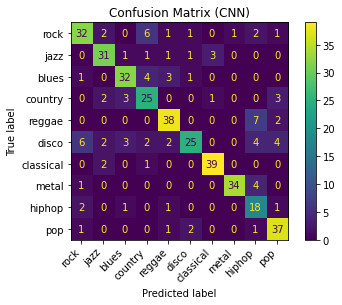

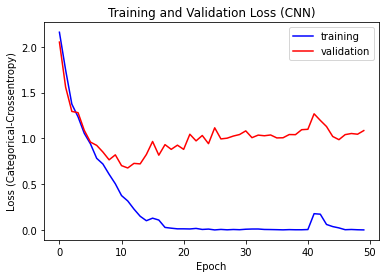

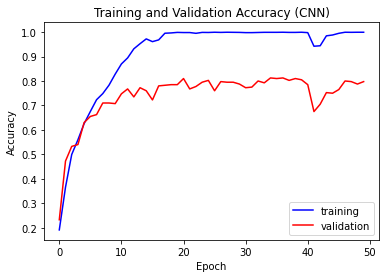

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Evaluate model on test set
pred_cnn = model_cnn.predict(data_test)
_, acc_cnn = model_cnn.evaluate(data_test, labels_test)
confm_cnn = metrics.confusion_matrix(labels_test.argmax(axis=1), pred_cnn.argmax(axis=1))
class_acc_cnn = confm_cnn.diagonal()/confm_cnn.sum(axis=1)

print('Test set accuracy: ' + str(acc_cnn))
print('=== Class based accuracies ===')
for genre_id in range(len(genres)):
  print(' ' + genres[genre_id] + ': ' + str(class_acc_cnn[genre_id]))

confm_disp = ConfusionMatrixDisplay(confusion_matrix=confm_cnn, display_labels=genres)
confm_disp.plot()
confm_disp.ax_.set_xticklabels(genres, rotation=45, ha='right')
plt.title('Confusion Matrix (CNN)')

# Extract training/validation losses
loss_train_cnn = history_cnn.history['loss']
loss_valid_cnn = history_cnn.history['val_loss']

# Plot training/validation losses
plt.figure()
plt.plot(loss_train_cnn, color='blue')
plt.plot(loss_valid_cnn, color='red')
plt.title('Training and Validation Loss (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Categorical-Crossentropy)')
plt.legend(['training','validation'])

# Extract training/validation accuracies
acc_train_cnn = history_cnn.history['accuracy']
acc_valid_cnn = history_cnn.history['val_accuracy']

# Plot training/validation accuracies
plt.figure()
plt.plot(acc_train_cnn, color='blue')
plt.plot(acc_valid_cnn, color='red')
plt.title('Training and Validation Accuracy (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['training','validation'])